# Tensorflow--神经网络处理分类问题

### 一.TFRecord文件
TFRecord是Tensorflow设计的一种存储数据的内置文件格式，可以方便高效地管理数据及这些数据的相关信息，利用它可以将数据快速加载到内存中。接下来介绍如何将数据写入TFRecord文件和从TFRecord中解析数据的过程

#### 1.将ndarray写入TFRecord文件
假设有3个三维的ndarray，尺寸依次为2行3列4深度，3行3列3深度和2行2列3深度。将这3个ndarray及其对应的尺寸(高，宽，深度)写入文件名为data1.tfrecord的TFRecord文件中

In [2]:
import tensorflow as tf
import numpy as np

# 创建文件
record=tf.python_io.TFRecordWriter("dataTest1.tfrecord")

# 高为2，宽为3，深度为4的三维ndarray
array1=np.array(
    [
        [[1,2,1,2],[3,4,2,9],[5,6,0,3]],
        [[7,8,1,6],[9,6,1,7],[1,2,5,9]]
    ]
    ,np.float32
)

# 高为3，宽为3，深度为3的三维ndarray
array2=np.array(
    [
        [[11,12,11],[13,14,12],[15,16,13]],
        [[17,18,11],[19,10,11],[11,12,15]],
        [[13,14,15],[18,11,12],[19,14,10]]
    ]
    ,np.float32
)

# 高为2，宽为2，深度为3的三维ndarray
array3=np.array(
    [
        [[21,23,21],[23,24,22]],
        [[27,28,24],[29,20,21]]
    ]
    ,np.float32
)

# 将上述3个ndarray存入一个列表
arrays=[array1,array2,array3]

# 循环处理上述列表中的每一个ndarray
for array in arrays:
    # 计算每一个ndarray的形状
    height,width,depth=array.shape
    # 将ndarray中的值转为字节类型
    array_raw=array.tostring()
    # ndarray的值及对应的高，宽及深度
    feature={
        'array_raw':
            tf.train.Feature(
                bytes_list=tf.train.BytesList(value=[array_raw])
            ),
        'height':
            tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'width':
            tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'depth':
            tf.train.Feature(int64_list=tf.train.Int64List(value=[depth]))
    }
    
    features=tf.train.Features(feature=feature)
    example=tf.train.Example(features=features)
    # 字符串序列化后写入文件
    record.write(example.SerializeToString())
    
record.close()

在上述程序中，首先得到每一个ndarray的高，宽和深度，然后利用ndarray的成员函数tostring()将ndarray转换为字节类型，并将这些数据存储在tf.train.Example对象中，再利用其成员函数SerializeToString()序列化为二进制字符串，最后利用TFRecordWriter对象的成员函数Write将序列化后的二进制字符串写入TFRecord文件中

#### 2.从TFRecord解析数据
首先利用函数tr.train.string_input_producer读取一个TFRecord文件列表，然后创建一个TFRecordReader对象，利用其成员函数读取TFRecord文件列表，最后利用函数tf,parse_single_example解析文件中的数据

In [3]:
import tensorflow as tf
import numpy as np

# 读取tfrecord文件列表
record_queue=tf.train.string_input_producer(['dataTest1.tfrecord'],num_epochs=2)

# 创建一个TFRecordReader对象
reader=tf.TFRecordReader()
_,serialized_example=reader.read(record_queue)

# j解析tfrecord中的数据，每次只解析一个
features=tf.parse_single_example(
    serialized_example,
    features={
        'array_raw':tf.FixedLenFeature([],tf.string),
        'height':tf.FixedLenFeature([],tf.int64),
        'width':tf.FixedLenFeature([],tf.int64),
        'depth':tf.FixedLenFeature([],tf.int64)
    }
)

# 解析出对应的值
array_raw=features['array_raw']
array=tf.decode_raw(array_raw,tf.float32) # 解码
height=features['height']
width=features['width']
depth=features['depth']

# 创建会话
session=tf.Session()
session.run(tf.global_variables_initializer())
session.run(tf.local_variables_initializer())
coord=tf.train.Coordinator()
threads=tf.train.start_queue_runners(sess=session,coord=coord)

# 循环5次解析文件流中的数据
for i in range(5):
    ndarray,h,w,d=session.run([array,height,width,depth])
    print("---第%(num)d次解析到的ndarray---"%{"num":i+1})
    print(ndarray)
    
coord.request_stop()
coord.join(threads)
session.close()

---第1次解析到的ndarray---
[ 1.  2.  1.  2.  3.  4.  2.  9.  5.  6.  0.  3.  7.  8.  1.  6.  9.  6.
  1.  7.  1.  2.  5.  9.]
---第2次解析到的ndarray---
[ 11.  12.  11.  13.  14.  12.  15.  16.  13.  17.  18.  11.  19.  10.  11.
  11.  12.  15.  13.  14.  15.  18.  11.  12.  19.  14.  10.]
---第3次解析到的ndarray---
[ 21.  23.  21.  23.  24.  22.  27.  28.  24.  29.  20.  21.]
---第4次解析到的ndarray---
[ 1.  2.  1.  2.  3.  4.  2.  9.  5.  6.  0.  3.  7.  8.  1.  6.  9.  6.
  1.  7.  1.  2.  5.  9.]
---第5次解析到的ndarray---
[ 11.  12.  11.  13.  14.  12.  15.  16.  13.  17.  18.  11.  19.  10.  11.
  11.  12.  15.  13.  14.  15.  18.  11.  12.  19.  14.  10.]


从打印结果可以看出，解析出的每个ndarray都是一维的，这是因为在写入文件时，首先将原数据转换为字节类型。当然我们也可以根据解析到的每个ndarray对应的高，宽和深度将其转换为三维的ndarray

In [4]:
import tensorflow as tf
import numpy as np

# 读取tfrecord文件列表
record_queue=tf.train.string_input_producer(['dataTest1.tfrecord'],num_epochs=2)

# 创建一个TFRecordReader对象
reader=tf.TFRecordReader()
_,serialized_example=reader.read(record_queue)

# j解析tfrecord中的数据，每次只解析一个
features=tf.parse_single_example(
    serialized_example,
    features={
        'array_raw':tf.FixedLenFeature([],tf.string),
        'height':tf.FixedLenFeature([],tf.int64),
        'width':tf.FixedLenFeature([],tf.int64),
        'depth':tf.FixedLenFeature([],tf.int64)
    }
)

# 解析出对应的值
array_raw=features['array_raw']
array=tf.decode_raw(array_raw,tf.float32) # 解码
height=features['height']
width=features['width']
depth=features['depth']

# 创建会话
session=tf.Session()
session.run(tf.global_variables_initializer())
session.run(tf.local_variables_initializer())
coord=tf.train.Coordinator()
threads=tf.train.start_queue_runners(sess=session,coord=coord)

# 循环5次解析文件流中的数据
for i in range(5):
    ndarray,h,w,d=session.run([array,height,width,depth])
    ndarray=np.reshape(ndarray,[h,w,d])
    print('---第%(num)d次解析到ndarray---'%{'num':i+1})
    print(ndarray)
    
coord.request_stop()
coord.join(threads)
session.close()

---第1次解析到ndarray---
[[[ 1.  2.  1.  2.]
  [ 3.  4.  2.  9.]
  [ 5.  6.  0.  3.]]

 [[ 7.  8.  1.  6.]
  [ 9.  6.  1.  7.]
  [ 1.  2.  5.  9.]]]
---第2次解析到ndarray---
[[[ 11.  12.  11.]
  [ 13.  14.  12.]
  [ 15.  16.  13.]]

 [[ 17.  18.  11.]
  [ 19.  10.  11.]
  [ 11.  12.  15.]]

 [[ 13.  14.  15.]
  [ 18.  11.  12.]
  [ 19.  14.  10.]]]
---第3次解析到ndarray---
[[[ 21.  23.  21.]
  [ 23.  24.  22.]]

 [[ 27.  28.  24.]
  [ 29.  20.  21.]]]
---第4次解析到ndarray---
[[[ 1.  2.  1.  2.]
  [ 3.  4.  2.  9.]
  [ 5.  6.  0.  3.]]

 [[ 7.  8.  1.  6.]
  [ 9.  6.  1.  7.]
  [ 1.  2.  5.  9.]]]
---第5次解析到ndarray---
[[[ 11.  12.  11.]
  [ 13.  14.  12.]
  [ 15.  16.  13.]]

 [[ 17.  18.  11.]
  [ 19.  10.  11.]
  [ 11.  12.  15.]]

 [[ 13.  14.  15.]
  [ 18.  11.  12.]
  [ 19.  14.  10.]]]


从TFRecord文件中随机解析数据
假设有3个尺寸同为1行2列3深度的ndarray，写入文件名为data2.tfrecord的TFRecord文件中，因为已经知道这3个ndarray的尺寸都是1行2列3深度，所以一般只存储原数据即可，不存储其高，宽，深度等信息

In [1]:
import tensorflow as tf
import numpy as np

record=tf.python_io.TFRecordWriter("dataTest2.tfrecord")

array1=np.array(
    [
        [[1,2,3],[4,5,6]],
    ]
    ,np.float32
)

array2=np.array(
    [
        [[11,12,13],[14,15,16]],
    ]
    ,np.float32
)

array3=np.array(
    [
        [[21,23,21],[23,24,22]],
    ]
    ,np.float32
)

arrays=[array1,array2,array3]

for array in arrays:
    array_raw=array.tostring()
    
    feature={
        'array_raw':
            tf.train.Feature(
                bytes_list=tf.train.BytesList(value=[array_raw])
            ),
    }
    
    features=tf.train.Features(feature=feature)
    example=tf.train.Example(features=features)
    
    record.write(example.SerializeToString())
record.close()

In [ ]:
import tensorflow as tf
import numpy as np

# 创建一个TFRecordReader对象
epochs=2
reader=tf.TFRecordReader()
record_queue=tf.train.string_input_producer(['dataTest2.tfrecord'],num_epochs=epochs)

_,serialized_example=reader.read(record_queue)

# 解析文件中的图像及其对应的标签
features=tf.parse_single_example(
    serialized_example,
    features={
        'array_raw':tf.FixedLenFeature([],tf.string)
    }
)

# 解码二进制数据
array_raw=features['array_raw']
array_raw=tf.decode_raw(array_raw,tf.float32) # 解码
array=tf.reshape(array_raw,[1,2,3])

# 每次从文件中读取2个数据
BatchSize=2
arrays=tf.train.shuffle_batch([array],BatchSize,1000+3*BatchSize,1000)

# 创建会话
session=tf.Session()
session.run(tf.global_variables_initializer())
session.run(tf.local_variables_initializer())
coord=tf.train.Coordinator()
threads=tf.train.start_queue_runners(sess=session,coord=coord)

# 循环2次,从文件中随机读取
for i in range(2):
    arrs=session.run([arrays])
    print('---第%(num)d次解析到ndarray---'%{'num':i+1})
    print(arrs)
    
coord.request_stop()
coord.join(threads)
session.close()

### 二.建立分类问题的数学模型

#### 1.数据类别
Tensorflow通过函数one_hot实现类别的数字化

In [1]:
import tensorflow as tf

v=tf.one_hot([9,2,7,3,0,4,8,6,1,3,4,8,6,1],depth=10,axis=1,dtype=tf.float32)

session=tf.Session()

print(session.run(v))

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]


以上代码中，函数one_hot中的参数depth=10代表有10个类别，axis代表按照每一行存储类别的数字化，因为有10类，所以返回结果有10列

#### 2.0图像与TFRecord
将ndarray写入TFRecord的方法，分别将每一个文件夹下的数字图像保存到一个TFRecord文件中，代码如下：

In [10]:
import tensorflow as tf
import os
import matplotlib.image as mp_image

N=10

for label in range(N):
    record=tf.python_io.TFRecordWriter(os.path.curdir+'/data/'+'data%(label)d.tfrecord'%{'label':label})
    curDir=os.path.curdir+'/data/'+str(label)+'/'
    fileList=os.listdir(curDir)
    
    for name in fileList:
        # 图片的路径和名称
        imagePath=curDir+name
        # 读取图片，数字化为ndarray
        image=mp_image.imread(imagePath)
        # 将ndarray二进制化
        img_raw=image.tostring()
        
        feature={
            'img_raw':
            tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_raw])),
            'label':
            tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
        }
        
        features=tf.train.Features(feature=feature)
        example=tf.train.Example(features=features)
        
        # 字符串序列化后写入文件
        record.write(example.SerializeToString())
        
    # 关闭文件流
    record.close()

介绍如何从这10个TFRecord文件中，每次随机读取3幅图片和对应的分类标签

[b'.\\data\\data0.tfrecord' b'.\\data\\data1.tfrecord'
 b'.\\data\\data2.tfrecord' b'.\\data\\data3.tfrecord'
 b'.\\data\\data4.tfrecord' b'.\\data\\data5.tfrecord'
 b'.\\data\\data6.tfrecord' b'.\\data\\data7.tfrecord'
 b'.\\data\\data8.tfrecord' b'.\\data\\data9.tfrecord']
---第1批图像---
---第1批图像中的第1张：标签为2---


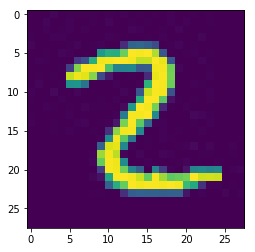

---第1批图像中的第2张：标签为5---


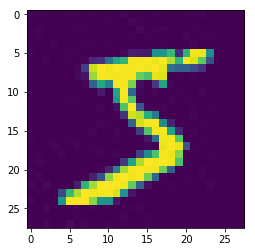

---第1批图像中的第3张：标签为6---


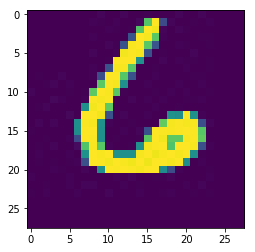

---第2批图像---
---第2批图像中的第1张：标签为7---


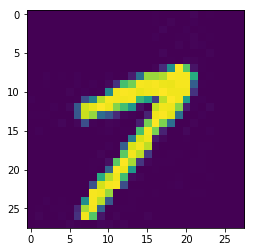

---第2批图像中的第2张：标签为1---


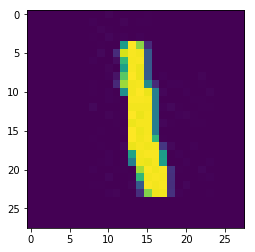

---第2批图像中的第3张：标签为3---


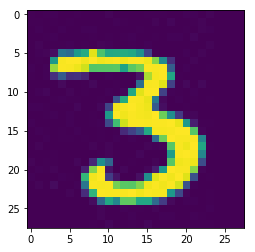

In [11]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt

H,W=28,28

files=tf.train.match_filenames_once(os.path.curdir+"/data/"+"data*.tfrecord")

# 创建TFRecordReader对象
reader=tf.TFRecordReader()
records_queue=tf.train.string_input_producer(files,num_epochs=2)
_,serialized_example=reader.read(records_queue)

# 解析文件中的图像及其对应的标签
features=tf.parse_single_example(
    serialized_example,
    features={
        'img_raw':tf.FixedLenFeature([],tf.string),
        'label':tf.FixedLenFeature([],tf.int64),
    }
)

# 解码二进制数据
img_raw=features['img_raw']
img_raw=tf.decode_raw(img_raw,tf.uint8)

# 转换成图片
img=tf.reshape(img_raw,[H,W])

# 标签
label=features['label']
label=tf.cast(label,tf.int64)

# 每次从文件中读取3张图片
BatchSize=3
img,label=tf.train.shuffle_batch([img,label],BatchSize,1000+3*BatchSize,1000)

session=tf.Session()
session.run(tf.global_variables_initializer())
session.run(tf.local_variables_initializer())

coord=tf.train.Coordinator()
threads=tf.train.start_queue_runners(sess=session,coord=coord)
print(session.run(files))

# 循环2次解析文件流中的数据
for i in range(2):
    print("---第%(num)d批图像---"%{'num':i+1})
    imgs,labels=session.run([img,label])
    
    for j in range(BatchSize):
        print("---第%(num)d批图像中的第%(index)d张：标签为%(l)d---"%{"num":i+1,"index":j+1,"l":labels[j]})
        
        plt.imshow(imgs[j,:,:])
        plt.show()

coord.request_stop()
coord.join(threads)
session.close()

#### 3.建立模型
全连接神经网络的输入层都是一维张量，而图像是高维张量(灰色图像是二维张量，彩色图像是三维张量)。如果把图像转换为一个全连接神经网络的输入，直接将高维张量拉伸为一个一维张量即可

In [4]:
import tensorflow as tf

# 构建全连接神经网络
def net(tensor):
    # 输入层，隐含层，输出层的神经元个数
    I,H1,O=784,200,10
    # 第1层的权重矩阵和偏置
    w1=tf.random_normal([I,H1],0,1,tf.float32)
    b1=tf.random_normal([H1],0,1,tf.float32)
    # 隐含层的结果，采用sigmoid激活函数
    l1=tf.matmul(tensor,w1)+b1
    sigma1=tf.nn.sigmoid(l1)
    
    # 第2层的权重矩阵和偏置
    w2=tf.random_normal([H1,O],0,1,tf.float32)
    b2=tf.random_normal([O],0,1,tf.float32)
    
    # 输出层的结果
    l2=tf.matmul(sigma1,w2)+b2
    return l2

# 读取图片文件
image=tf.read_file("0.jpg","r")

# 将图片文件解码为Tensor
image_tensor=tf.image.decode_jpeg(image)

# 图像张量的形状
length=tf.size(image_tensor) # length=28*28

# 改变形状，拉伸为1个一维张量，按行存储
t=tf.reshape(image_tensor,[1,length])

# 数据类型转换，转换为float32类型
t=tf.cast(t,tf.float32)

# 标准化处理
t=t/255.0

output=net(t)
session=tf.Session()

print(session.run(output))

[[-13.0977354    4.13779497   5.97057438  -7.29600286 -11.34489727
   -4.86154842  -2.60884142   0.13025093  -1.98705816  -0.21878564]]


最理想的情况是经过全连接神经网络的输出结果_y(即全连接神经网络输出层的值)与人工分类的结果y相等

### 三.损失函数与训练模型
对于分类问题的损失函数，常用的是sigmoid交叉熵和softmax交叉熵

#### 1.sigmoid损失函数
Tensorflow通过函数sigmoid_cross_entropy_with_logits(labels,logits,name)实现sigmoid交叉熵，其中labels代表人工分类标签，是一个N行C列的二维张量，代表N个样本的标签，每一行代表一个样本的分类标签，logits代表输出层的结果，与labels的尺寸相同，每一行代表一个样本经过全连接神经后的输出值，利用求和函数reduce_sum对函数sigmoid_cross_entropy_logits返回的结果求和，其结果为sigmoid交叉熵损失函数

In [5]:
import tensorflow as tf

# 输出层的值
logits=tf.constant(
    [
        [-13.0977354,4.13779497,5.97057438,-7.29600286,-11.34489727,-4.86154842,-2.60884142,0.13025093,-1.98705816,-0.21878564]
    ]
)

# 人工分类的标签
labels=tf.constant([[1,0,0,0,0,0,0,0,0,0]],tf.float32)

# sigmoid交叉熵
entroy=tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=labels)

# 损失值
loss=tf.reduce_sum(entroy)

session=tf.Session()
print(session.run(loss))

24.7825


#### 2.softmax损失函数
softmax计算原理
Tensorflow通过函数softmax(logits,axis=None,name=None,dim=None)实现softmax处理

In [6]:
import tensorflow as tf
# 输入张量
t=tf.constant([2,5,3],tf.float32)
x=tf.log(t)
# softmax处理
s=tf.nn.softmax(x,0)
# 创建会话
session=tf.Session()

print(session.run(s))

[ 0.19999999  0.5         0.29999998]


函数tf.nn.softmax可以处理多维张量

In [7]:
import tensorflow as tf

# 输入张量
x=tf.constant(
    [
        [1,2,1],
        [2,2,2]
    ]
    ,tf.float32
)

# 分别对每一行(沿"1"方向)进行softmax处理
s=tf.nn.softmax(x,1)

session=tf.Session()

print(session.run(s))

[[ 0.21194157  0.57611692  0.21194157]
 [ 0.33333334  0.33333334  0.33333334]]


softmax交叉熵及softmax损失函数
利用Tensorflow的求和函数reduce_sum和函数tf.nn.softmax定义softmax损失函数为tf.reduce_sum(-y*tf.nn.softmax(_y,1))

In [8]:
import tensorflow as tf

# 假设_y为全连接神经网络的输出(输出层有3个神经元)
_y=tf.constant(
    [
        [0,2,-3],
        [4,-5,6]
    ]
    ,tf.float32
)

# 人工分类结果
y=tf.constant(
    [
        [1,0,0],
        [0,0,1]]
    ,tf.float32
)

# softmax熵
_y_softmax=tf.nn.softmax(_y)
entroy=tf.reduce_sum(-y*tf.log(_y_softmax),1)

# loss损失函数
loss=tf.reduce_sum(entroy)

session=tf.Session()

print(session.run(loss))

2.25979


以上代码实现中，使用了乘法运算符*和函数tf.nn.softmax实现softmax熵，Tensorflow将这两个运算封装成了一个函数softmax_cross_entroy_with_logits_v2,
即tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(logits,labels))

In [10]:
import tensorflow as tf

# 假设_y为全连接神经网络的输出(输出层有3个神经元)
_y=tf.constant([[0,2,-3],[4,-5,6]],tf.float32)

# 人工分类结果
y=tf.constant([[1,0,0],[0,0,1]],tf.float32)

# softmax熵
entroy=tf.nn.softmax_cross_entropy_with_logits(logits=_y,labels=y)

# loss损失函数
loss=tf.reduce_sum(entroy)

session=tf.Session()

print(session.run(loss))

2.25979


#### 3.训练和评估模型
直到现在我们已经掌握了：
1.从TFRecord中解析数据
2.构建全连接神经网络
3.构造损失函数
4.梯度下降法

In [11]:
import tensorflow as tf
import os

# 占位符
x=tf.placeholder(tf.float32,[None,28*28])
labels=tf.placeholder(tf.float32,[None,10])

# 第1步：解析数据
nums=33 # 所有训练样本的个数

# 得到文件夹./data/下的所有tfrecord文件
files=tf.train.match_filenames_once(os.path.curdir+"/data/"+"data*.tfrecord")

# 创建TFRecordReader对象
num_epochs=1000
reader=tf.TFRecordReader()
records_queue=tf.train.string_input_producer(files,num_epochs=num_epochs)
_,serialized_example=reader.read(records_queue)

# 解析文件中的图像及其对应的标签
features=tf.parse_single_example(
        serialized_example,
        features={
                'img_raw':tf.FixedLenFeature([],tf.string),
                'label':tf.FixedLenFeature([],tf.int64),
                }
                                 )


# 解码二进制数据
img_raw=features['img_raw']
img_raw=tf.decode_raw(img_raw,tf.uint8)
img=tf.reshape(img_raw,[28*28])
img=tf.cast(img,tf.float32)
img=img/255.0

# 标签
label=features['label']
label=tf.cast(label,tf.int64)
label_onehot=tf.one_hot(label,10,dtype=tf.float32)

# 每次从文件中读取3张图片
BatchSize =3
imgs,labels_onehot=tf.train.shuffle_batch([img,label_onehot],BatchSize,1000+3*BatchSize,1000)


# 第2步：构建全连接神经网络
# 输入层，隐含层，输出层的神经元个数
I,H1,O=784,200,10

# 输入层到隐含层的权重矩阵和偏置
w1=tf.Variable(tf.random_normal([I,H1],0,1,tf.float32),dtype=tf.float32,name='w1')
b1=tf.Variable(tf.random_normal([H1],0,1,tf.float32),dtype=tf.float32,name='b1')

# 隐含层的结果，采用sigmoid激活函数
l1=tf.matmul(x,w1)+b1
sigma1=tf.nn.sigmoid(l1)

# 第2层的权重及偏置
w2=tf.Variable(tf.random_normal([H1,O],0,1,tf.float32),dtype=tf.float32,name='w2')
b2=tf.Variable(tf.random_normal([O],0,1,tf.float32),dtype=tf.float32,name='b2')

# 输出层的结果
logits=tf.matmul(sigma1,w2)+b2

# 第3步：构造损失函数
loss=tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(labels=labels_onehot,logits=logits))

# 第4步：梯度下降
opti=tf.train.AdamOptimizer(0.001,0.9,0.999,1e-8).minimize(loss)

session=tf.Session()
session.run(tf.global_variables_initializer())
session.run(tf.local_variables_initializer())

coord=tf.train.Coordinator()
threads=tf.train.start_queue_runners(sess=session,coord=coord)

for i in range(num_epochs):
    for n in range(int(nums/BatchSize)):
        imgs_arr,lables_onehot_arr=session.run([imgs,labels_onehot])
        session.run(opti,feed_dict={x:imgs_arr,labels:lables_onehot_arr})
        
coord.request_stop()
coord.join(threads)
session.close()

OutOfRangeError: RandomShuffleQueue '_2_shuffle_batch/random_shuffle_queue' is closed and has insufficient elements (requested 3, current size 1)
	 [[Node: shuffle_batch = QueueDequeueManyV2[component_types=[DT_FLOAT, DT_FLOAT], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](shuffle_batch/random_shuffle_queue, shuffle_batch/n)]]

Caused by op 'shuffle_batch', defined at:
  File "E:\Anaconda\envs\mytensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "E:\Anaconda\envs\mytensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "E:\Anaconda\envs\mytensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "E:\Anaconda\envs\mytensorflow\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "E:\Anaconda\envs\mytensorflow\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "E:\Anaconda\envs\mytensorflow\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "E:\Anaconda\envs\mytensorflow\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "E:\Anaconda\envs\mytensorflow\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "E:\Anaconda\envs\mytensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "E:\Anaconda\envs\mytensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "E:\Anaconda\envs\mytensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "E:\Anaconda\envs\mytensorflow\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "E:\Anaconda\envs\mytensorflow\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "E:\Anaconda\envs\mytensorflow\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "E:\Anaconda\envs\mytensorflow\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "E:\Anaconda\envs\mytensorflow\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "E:\Anaconda\envs\mytensorflow\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "E:\Anaconda\envs\mytensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "E:\Anaconda\envs\mytensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "E:\Anaconda\envs\mytensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-33348cd51422>", line 44, in <module>
    imgs,labels_onehot=tf.train.shuffle_batch([img,label_onehot],BatchSize,1000+3*BatchSize,1000)
  File "E:\Anaconda\envs\mytensorflow\lib\site-packages\tensorflow\python\training\input.py", line 1217, in shuffle_batch
    name=name)
  File "E:\Anaconda\envs\mytensorflow\lib\site-packages\tensorflow\python\training\input.py", line 788, in _shuffle_batch
    dequeued = queue.dequeue_many(batch_size, name=name)
  File "E:\Anaconda\envs\mytensorflow\lib\site-packages\tensorflow\python\ops\data_flow_ops.py", line 457, in dequeue_many
    self._queue_ref, n=n, component_types=self._dtypes, name=name)
  File "E:\Anaconda\envs\mytensorflow\lib\site-packages\tensorflow\python\ops\gen_data_flow_ops.py", line 946, in _queue_dequeue_many_v2
    timeout_ms=timeout_ms, name=name)
  File "E:\Anaconda\envs\mytensorflow\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "E:\Anaconda\envs\mytensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "E:\Anaconda\envs\mytensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

OutOfRangeError (see above for traceback): RandomShuffleQueue '_2_shuffle_batch/random_shuffle_queue' is closed and has insufficient elements (requested 3, current size 1)
	 [[Node: shuffle_batch = QueueDequeueManyV2[component_types=[DT_FLOAT, DT_FLOAT], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](shuffle_batch/random_shuffle_queue, shuffle_batch/n)]]


以上代码中函数tf.train.shuffle_batch和tf.train.AdamOptimizer的组合使用其实就实现了用随机梯度下降法处理函数的最小值